In [56]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
from scipy.signal import convolve
import scipy
from joblib import Parallel, delayed
import time
from scipy import sparse

num_cores = 32

%run initMethods.py
%run makeGif.py
%run methods.py

In [60]:
params = { #parameters relevant for the equations
    "Nh":          1000000,
    "N0":           100000,
    "R0":              20,
    "M":                1, #Also L, total number of spacers
    "D":                3, #Unused
    "mu":             0.02, #mutation rate
    "v0":              0.5,
    "gamma_shape":     20, 
    "Np":               0, #Number of Cas Protein
    "dc":               3, #Required number of complexes to activate defence
    "h":                4, #coordination coeff
    "r":              1000, #cross-reactivity kernel
    "rho":            5e-5, #spacer sharing coeff
}
sim_params = { #parameters relevant for the simulation (including Inital Valuess)
    "xdomain":                  200,
    "dx":                         1,
    "t0":                         0, 
    "tf":                       100,
    "dt":                         1,
    "initial_mean":           [0,0],
    "initial_var":               50,
    "n_step_prior":               5,
    "conv_size":               1000,
    "num_threads":               28,
    "tail_axis":            [1, 1],
}

In [ ]:
n = init_guassian_parallel(params["N0"], sim_params)
nh = init_exptail_parrallel(params["Nh"], params, sim_params)
kernel = init_kernel(params, sim_params)

In [102]:
def growth_calc(n_split, nh_split, params, sim_params):
    if np.sum(n_split) > 0:
        p_split = coverage_convolution(nh_split, kernel, params, sim_params)
        f_split = fitness_spacers(n_split, nh_split, p_split, params, sim_params)
        n_split = virus_growth(n_split, f_split, params, sim_params)
    return n_split

def immunity_calc(nh_split, n_split, params, sim_params):
    
    nh_split = immunity_gain(nh_split, n_split, params, sim_params)
    nh_split = immunity_loss(nh_split, n_split, params, sim_params)
    return nh_split

In [70]:
R0_sweep = [20]
kernel = init_kernel(params, sim_params)
foldername = "test5/"

for R0 in R0_sweep:
    params["R0"] = R0
    st0 = time.time()
    n = init_guassian_parallel(params["N0"], sim_params)
    nh = init_exptail_parallel(params["Nh"], params,sim_params)
    nh = init_uniform(params["Nh"], sim_params)
    st1 = time.time()

    et0 = time.strftime("%H:%M:%S", time.gmtime(st1 - st0))
    print(f"Reproduction Rate R0: {R0} | init time: {et0}")

    for i in range(1000):
        st1 = time.time()
        p = coverage_parrallel_convolution(nh, kernel, params, sim_params)
        st2 = time.time()
        f = fitness_spacers(n, nh, p, params, sim_params) #f is now a masked array (where mask is where eff_R0 = 0)
        st3 = time.time()
        f_avg = np.sum(f*n/np.sum(n))
        n = virus_growth(n, f-f_avg, params, sim_params) #update
        st4 = time.time()

        et1 = time.strftime("%H:%M:%S", time.gmtime(st2 - st1))
        et2 = time.strftime("%H:%M:%S", time.gmtime(st3 - st2))
        et3 = time.strftime("%H:%M:%S", time.gmtime(st4 - st3))
        print("Convolution Time:", et1, "| Fitness Spacer Time", et2, "| Virus Growth Time", et3)

        n = mutation_parallel(n, params, sim_params)
        st5 = time.time()
        nh = immunity_update_parallel(nh, n, params, sim_params) #update nh
        st6 = time.time()


        et4 = time.strftime("%H:%M:%S", time.gmtime(st5 - st4))
        et5 = time.strftime("%H:%M:%S", time.gmtime(st6 - st5))
        print("Mutation Parallel:", et4, "| Immunity Update Parallel:", et5, "| Number of Phage:", np.sum(n))

        if (i%20 == 0 or i < 20):
            n_sparse = sparse.csr_matrix(n)
            sparse.save_npz(foldername+f"sp_frame_n{i}",n_sparse)
            nh_sparse = sparse.csr_matrix(nh)
            sparse.save_npz(foldername+f"sp_frame_nh{i}",nh_sparse)
            # np.save(f"test5/frame_n{i}.npy", n)
            # np.save(f"test5/frame_nh{i}.npy", nh)

        if np.sum(n) >= 10*params["Nh"]:
            break

Reproduction Rate R0: 20 | init time: 00:00:12


In [12]:
foldername= "test4/"

# makeGif(nh_frames, foldername + "/" + "nh")
# makeGif(n_frames, foldername + "/" + "n")
write2json(foldername + "/", params, sim_params)

In [68]:
n_single = sparse.load_npz(foldername+f"sp_frame_nh{0}.npz").todense()

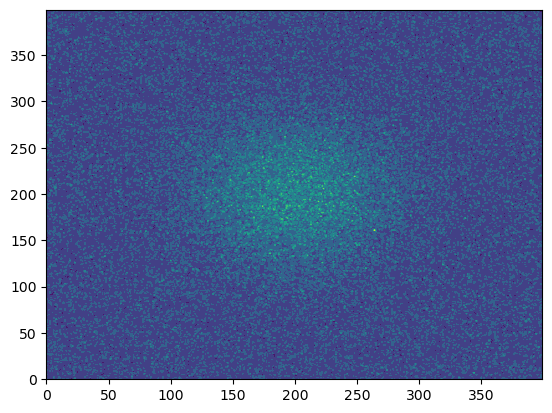

In [69]:
plt.contourf(n_single)

In [49]:
n_single = []
for i, time in enumerate(range(0, 1000, 200)):
    n_single.append(np.load(f"test4/frame_nh{time}.npy"))

n_single = np.array(n_single).squeeze()

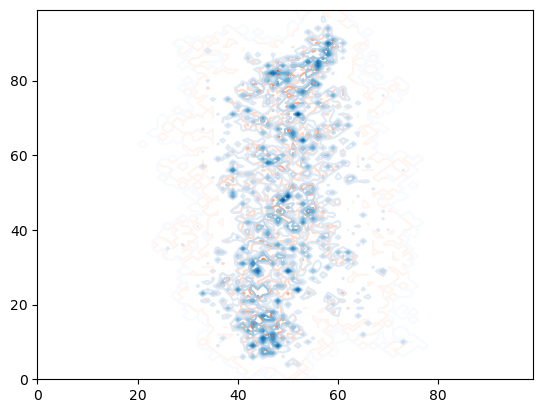

In [19]:
center = sim_params["xdomain"]
size = 50

plt.figure()
plt.contour(n_single[center-size:center+size, center-size:center+size], cmap = "Reds")
plt.contour(nh_single[center-size:center+size, center-size:center+size], cmap = "Blues")
plt.show()

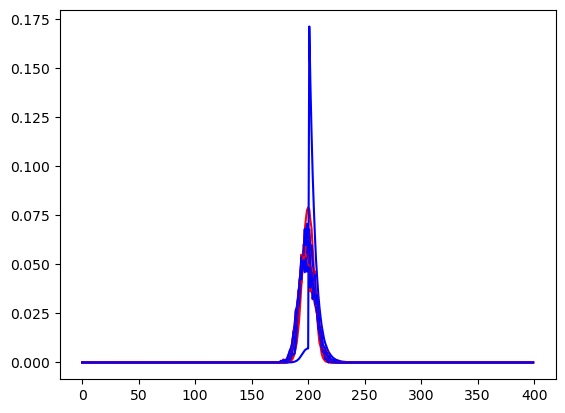

In [54]:
n_slice2 = np.sum(n_single, axis=1)
for i in range(n_slice.shape[0]):
    plt.plot(n_slice[i, :]/np.sum(n_slice[i, :]), label = f"time_n: {i*200}", color = "red")
    plt.plot(n_slice2[i, :]/np.sum(n_slice2[i,:]), label = f"time_nh: {i*200}", color = "blue")
